## 5copy: Just copying to see if it still works?


In [1]:
import os, sys
import copy as copyroot
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
from fastai2.basics import *
from fastai2.vision.all import *
%load_ext autoreload
%autoreload 2

from module.mnist_helpers import build_df, eda_fig_1, build_dls
from module.mnist_models import FeatsNet
from module.mnist_metrics import metrics_df

### Setup

In [3]:
path = untar_data(URLs.MNIST_TINY)
df = build_df(path)

y_names = ['point_topleft_x', 'point_topleft_y',]

db =   DataBlock(blocks=(ImageBlock(cls=PILImageBW), 
                         PointBlock), 
                splitter=RandomSplitter(seed=0),
                get_x=ColReader('fn', pref=path),
                get_y=ColReader(y_names),
                )
dl = db.dataloaders(df)

dls_tl = build_dls(target='topleft')
# x, y = dls.one_batch()
# x.shape

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.002511886414140463)

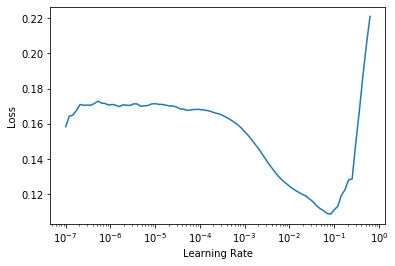

In [5]:
fn = FeatsNet(feats=['pts12', 'pts22'])
learn = Learner(dl, fn, loss_func=MSELossFlat(), y_range=(-1.,1.))
learn.lr_find()

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.0030199517495930195)

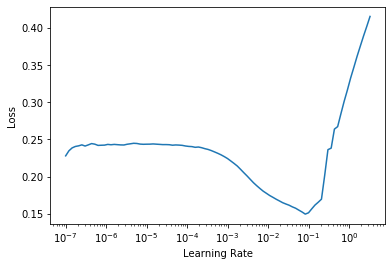

In [7]:
fn = FeatsNet(feats=['pts12', 'pts22'])
learn = Learner(dl, fn, loss_func=MSELossFlat())
learn.lr_find()

### Big and Decently Good Fit
We train the learner for 90 epochs and a higher LR to acheive a pretty good fit, but still well below where it a.) should be with perfect features, b.) the perf of basic-ML algos (e.g. in metrics-4.ipynb) with the same features.

In [8]:
fn = FeatsNet(feats=['pts12', 'pts22'])
learn = Learner(dl, fn, loss_func=MSELossFlat(), y_range=(-1.,1.))
learn.fit(40,lr=2e-2)

epoch,train_loss,valid_loss,time
0,0.116072,0.066358,00:03
1,0.081662,0.035727,00:02
2,0.060996,0.018419,00:03
3,0.048101,0.015949,00:03
4,0.038954,0.012678,00:02
5,0.032080,0.007967,00:03
6,0.026621,0.005213,00:03
7,0.022241,0.004358,00:02
8,0.018719,0.003639,00:03
9,0.015923,0.003538,00:03


In [9]:
df = metrics_df(learn, 
           s_model="FeatsNet2.1122",
           s_details="feats=11,12 | epochs=90, lr=1e-2",
           s_target="topleft"
          )

In [10]:
df

,model,details,target,split,mse,mae,r2,dist_avg,dist_r2,sqdist_avg,sqdist_r2
0,FeatsNet2.1122,"feats=11,12 | epochs=90, lr=1e-2",topleft,valid,0.001023,0.024489,0.937638,0.037525,0.826302,0.002046,0.967980
1,FeatsNet2.1122,"feats=11,12 | epochs=90, lr=1e-2",topleft,train,0.001019,0.024844,0.936560,0.038675,0.835559,0.002038,0.973165


### Showing the Characteristic tail deviation

In [11]:
preds = learn.get_preds()

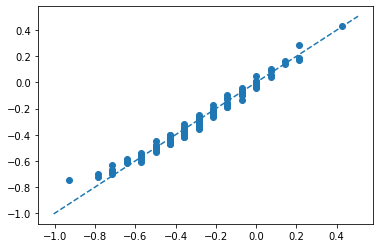

In [12]:
plt.scatter(preds[1].view(-1,2)[:,0], preds[0][:,0], )
tmp = torch.tensor((plt.xlim(), plt.ylim())).flatten()
lo, hi = tmp.min().item(), tmp.max().item()
plt.plot([lo,hi],[lo,hi], linestyle='--');

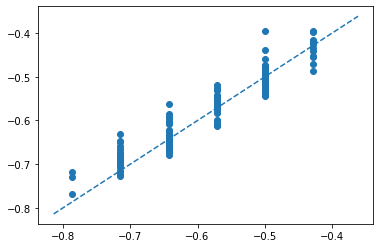

In [13]:
plt.scatter(preds[1].view(-1,2)[:,1], preds[0][:,1], )
tmp = torch.tensor((plt.xlim(), plt.ylim())).flatten()
lo, hi = tmp.min().item(), tmp.max().item()
plt.plot([lo,hi],[lo,hi], linestyle='--');

### Batch into Model

In [16]:
b = dl.one_batch()

In [23]:
ind_coord = 0
pred =  learn.model(b[0])[:,ind_coord].detach()
actual =                     b[1][:,0,ind_coord].detach()

In [24]:
pred.shape, actual.shape

(torch.Size([64]), torch.Size([64]))

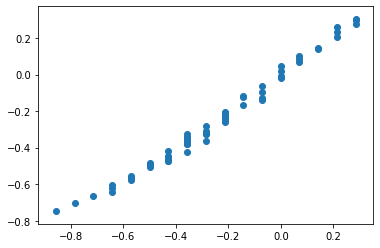

In [25]:
plt.scatter(actual, pred)

### Train a restricted region Learner, analyze
It's slightly worse but the y_range doesn't seem to have an effect?

In [26]:
fn = FeatsNet(feats=['pts12', 'pts22'])
learn_r = Learner(dl, fn, loss_func=MSELossFlat(), y_range=(-.5,.5))
learn_r.fit(40,lr=2e-2)

epoch,train_loss,valid_loss,time
0,0.099107,0.039970,00:04
1,0.068326,0.024004,00:03
2,0.051595,0.026152,00:04
3,0.041042,0.012980,00:04
4,0.033352,0.010235,00:04
5,0.027297,0.005754,00:04
6,0.022390,0.004568,00:04
7,0.018668,0.003656,00:04
8,0.015750,0.003528,00:03
9,0.013475,0.003177,00:04


In [27]:
mets = metrics_df(learn_r, 
           s_model="",
           s_details="",
           s_target=""
          )
mets

,model,details,target,split,mse,mae,r2,dist_avg,dist_r2,sqdist_avg,sqdist_r2
0,,,,valid,0.001251,0.027820,0.911047,0.043613,0.798125,0.002501,0.960866
1,,,,train,0.001180,0.027163,0.917729,0.043308,0.815861,0.002359,0.968941


In [28]:
preds = learn_r.get_preds()

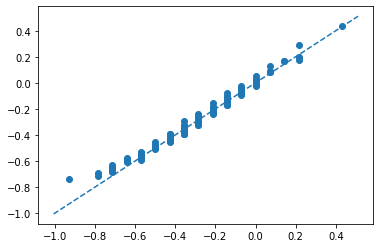

In [29]:
plt.scatter(preds[1].view(-1,2)[:,0], preds[0][:,0], )
tmp = torch.tensor((plt.xlim(), plt.ylim())).flatten()
lo, hi = tmp.min().item(), tmp.max().item()
plt.plot([lo,hi],[lo,hi], linestyle='--');

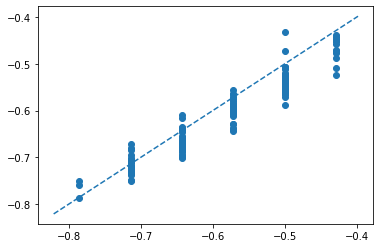

In [30]:
plt.scatter(preds[1].view(-1,2)[:,1], preds[0][:,1], )
tmp = torch.tensor((plt.xlim(), plt.ylim())).flatten()
lo, hi = tmp.min().item(), tmp.max().item()
plt.plot([lo,hi],[lo,hi], linestyle='--');